<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S72_drone_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

In [3]:
import math
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

# Multi-rotor Aircraft

> An amazing way to fly in 3D.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [1]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(7, 2, "steampunk", 1))

The kinematics of quadrotors and multicopters are those of simple rigid 3D bodies. Many different coordinate frame conventions are used in the literature. I introduce one good choice below, and convert equations from the literature to this convention where needed.

The kinematics equations are most useful for navigation and control when expressed in the navigation frame $\mathcal{N}$, which for MAV applications is almost universally assumed to be non-rotating and aligned with gravity, but can otherwise be defined arbitrarily, e.g., **East-North-Up (ENU)**. The origin of the navigation frame is often chosen as the take-off point, but does not have to be.

We also define a body frame $\mathcal{B}$ as having its origin at the center of mass of the vehicle. Following convention in aerospace applications, we fix the the x-axis as pointing to the front of the vehicle (not always the direction of travel), the y-axis as pointing to the left, and the z-axis pointing up, the sol-called **FLU convention**. 

We then define, respectively,

• the vehicle's position $r^{n}\doteq[x,y,z]^{T}$,

• its linear velocity $v^n=\dot{r^{n}}\doteq[u,v,w]^{T}$,

• the attitude $R^n_b\doteq[i^b,j^b,k^b]\in SO(3)$, a $3\times 3$ rotation matrix from $\mathcal{B}$ to $\mathcal{N}$,

• the body angular velocity $\omega^b\doteq[p,q,r]^{T}$.

Above the superscript $n$ and $b$ denote quantities expressed in the *navigation* and *body* frame, respectively. 

## Drone Dynamics

Let us take the [Skydio 2+](https://www.skydio.com/skydio-2-plus) as a prototypical and relevant example. Its mass, with battery, is 800g, but let's just say $1kg$ to make the calculations easier. Its dimensions are $229mm x 274mm$, but let's assume the motors are at $(+/- 0.10m, +/- 0.10m)$, which is not too far off.

## Hover
To hover, assuming $g=10m/s^2$, the four rotors have to provide a thrust of 10N upwards to compensate for gravity, i.e., 2.5N per motor. Of course, we need to be able to accelerate upwards, so let's assume each motor can provide up to double that, i.e., 0 to 5N. So, while the drone is level, here are some sample accelerations we can deliver:

- $f_i=0N$ for $i\in{1..4}$: downwards acceleration at $-10\frac{m}{s^2}$.
- $f_i=2.5N$ for $i\in{1..4}$: stable hover $0\frac{m}{s^2}$.
- $f_i=5N$ for $i\in{1..4}$: upwards acceleration at $10\frac{m}{s^2}$.

In general, the force $F^b_z$ aligned with the body Z-axis will be  

$$
F^b_z = \sum_{i=1}^4 f_i
$$

## Forward Flight

Of course, when we *tilt* the quadrotor forwards, we will direct some of that thrust towards generating horizontal acceleration. To get a handle on this, we need to calculate the thrust in the *navigation* frame, but this is just a matter of multiplying with the rotation matrix $R^n_b$:

$$
F^n = R^n_b \begin{bmatrix}0 \\ 0 \\ F^b_z\end{bmatrix} = \hat{z}^n_b F^b_z
$$

where $\hat{z}^n_b$ is the third column of $R^n_b$, i.e., this is simply the Z-axis $\hat{z}$ of the body frame, expressed in the navigation frame. *In other words, the thrust in the navigation frame is always aligned with the body's Z-axis, and hence by rotating the quadrotor appropriately we can any thrust direction we desire*.

Let us assume that the FLU body frame is currently oriented along the Y-axis of the ENU navigation frame, i.e., we are flying NORTH, then if we tilt forward with an angle of $\theta$ with respect to vertical, we obtain 

$$
F^n = \begin{bmatrix}0 \\ \sin \theta \\ \cos \theta\end{bmatrix} F^b_z
$$

and hence if we want to maintain level flight, we need to keep compensating for gravity by maintaining

$$
\cos \theta F^b_z = 10N.
$$

That in turn means that the forward trust (along the navigation Y-axis) will be

$$
F^n_y = \sin \theta F^b_z = \sin \theta \frac{10N}{\cos \theta} = \tan \theta \cdot 10N 
$$


## Maximum Tilt and Thrust

We are also constrained, however, by the maximum thrust $F^b_z$ we can deliver, which is 20N. Hence,

$$
F^b_z = \frac{10N}{\cos \theta} \leq 20N \rightarrow \cos \theta \geq 0.5 \rightarrow -60^\circ \leq \theta \leq 60^\circ,
$$

the maximum tilt angle is 60 degrees. At that maximum tilt angle, we have

$$
F^n_y = \tan \theta_{\max} \cdot 10N \approx 17N 
$$

So, we are limited to $17N$ of forward thrust, and this when tilt very aggressively at 60 degrees. If we tilt more, we can improve thrust even more (up to 20N) but the drone will start falling out of the sky. 

## Drag and Maximum Velocity

Importantly, constant forward thrust does *not* mean that the drone will continue accelerating, because of *drag*. In fact, from the spec-sheet of the Skydio-2 we see that the top speed (in autonomous mode) is 36Mph, which is about $16m/s$, and the theoretical top speed is probably more like $20m/s$. Since drag increases *quadratically* with velocity, we can calculate the corresponding drag coefficient as the drag force has to exactly balance the maximum forward thrust at the top speed:

$$
17N = k_d v_{top}^2 = k_d 20^2 m^2/s^2 \rightarrow k_d = 0.0425
$$

Now that we have the drag coefficient $k_d$, we can calculate a simple mapping from tilt angle $\theta$ to forward velocity. Indeed, given tilt $\theta$, can calculate the forward thrust $F^n_y$ in the navigation frame, and the velocity can be calculate equating that to the drag force $k^d v^2$:

$$
F^n_y = \tan \theta \cdot 10N = k_d v^2 \rightarrow v = \sqrt{\frac{\tan \theta \cdot 10}{k_d}} = \sqrt{\frac{10}{k_d}} \sqrt{\tan \theta} \approx 15 \sqrt{\tan \theta}
$$

In [4]:
vmap = {}
for theta in [0,1,5,10,15,20,30,40,50]:
  vmap[theta] = 15 * math.sqrt(math.tan(math.radians(theta)))
  print(f"v({theta}) ~ {round(vmap[theta])} m/s")

v(0) ~ 0 m/s
v(1) ~ 2 m/s
v(5) ~ 4 m/s
v(10) ~ 6 m/s
v(15) ~ 8 m/s
v(20) ~ 9 m/s
v(30) ~ 11 m/s
v(40) ~ 14 m/s
v(50) ~ 16 m/s


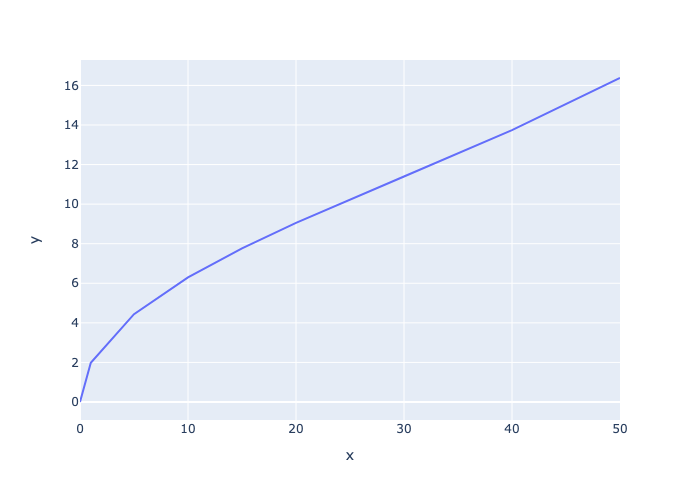

In [5]:
px.line(x=list(vmap.keys()), y= list(vmap.values()))

## Control

The rotational dynamics are an order of magnitude faster, so one control strategy is to assume that you have almost complete control over the orientation, with a very fast response.

Finally, we have complete freedom over horizontal direction, and the drone does not *have* to maintain hover: we can move up and down at the same time that we are moving horizontally. In that case we have to calculate the constant horizontal and vertical velocity separately.

## Full Rigid-Body Kinematics*

Below I develop all attitude kinematics and dynamics directly on $SO(3)$, following Murray et al. (1994).
In particular, the vehicle's kinematics are given by 

$$
\begin{align}
\dot{r}^{n}	&= v^n \\
\dot{R}^n_b	&= R^n_b\hat{\omega}^b
\end{align}
$$

where the $3\times 3$ skew-symmetric matrix $\hat{\omega}^b\doteq (R^n_b)^{T}\dot{R}^n_b$ is obtained from the 3-vector $\omega^b$ as the as follows:

$$
\hat{\omega}^b\doteq\begin{bmatrix}
 & -\omega^b_{z} & \omega^b_{y}\\
\omega^b_{z} &  & -\omega^b_{x}\\
-\omega^b_{y} & \omega^b_{x}
\end{bmatrix}.
$$

Note $\hat{\omega}^b\in so(3)$, the Lie algebra associated with the 3D rotation group $SO(3)$. 
Also, the kinematics can also expressed using the spatial angular velocity $\omega^n\doteq R^n_b\omega^b$, as follows

$$
\dot{R}^n_b	= \hat{\omega}^n R^n_b
$$

However, it is much easier to visualize and calculate the angular velocity in the body frame (see Section [sec:Dynamics]).

## Simulation aka Forward Integrating*

If time histories $v^n(t)$ and $\omega^b(t)$ for the linear and angular velocities are available, the vehicle's position $r^{n}(t)$ and attitude $R^n_b(t)$ can be integrated by Equations 

The translation can easily be done using any integration scheme. The attitude part can be done in discrete time by

$$
R^n_{b,k+1}\approx R^n_{b,k}e^{h\hat{\omega}^b}
$$

where h is the sample time and $\exp\left(h\hat{\omega}^b\right)$ is the *exponential map* from $so(3)$ to $SO(3)$. This assumes $\omega^b$ is constant over the sample period, and hence this is equivalent to Euler's method for forward integration. 
Since $\exp\left(h\hat{\omega}^b\right)\approx I+h\hat{\omega}^b$ for small $h$, we can also approximate Equation [eq:Euler-1] by 

$$
\begin{align}
R^n_{b,k+1}
&\approx R^n_{b,k} (I+h\hat{\omega}^b) 
& = R^n_{b,k}
\begin{bmatrix}
1 & -h\omega^b_{z} & h\omega^b_{y}\\
h\omega^b_{z} & 1 & -h\omega^b_{x}\\
-h\omega^b_{y} & h\omega^b_{x} & 1
\end{bmatrix}
\end{align}
$$

but this will require re-normalizing to ensure that $R^n_{b,k+1}\in SO(3)$. 

## Full Rigid-Body Dynamics*

> Not hard to write down, but harder to understand.

Ultimately we need to move a quadrotor to provide forces by the for rotors, which will produce a force and a moment on the quadrotor body. These in turn will generate linear and angular accelerations, through the quadrotor **dynamics**.

To start, everyone knows the famous Newton's law:

$$
F^n = m \dot{v}^n
$$

where the **mass** m is a scalar *resisting* motion: the higher the mass, the higher the force needed to produce an acceleration in any dimension. Note that we could consider $m$ to be a diagonal matrix with the mass on the diagonal: acceleration is resisted the same way in all three axes, in whatever coordinate frame we choose.

The same is true for rotational motion

$$
\tau^b = I \dot{\omega}^b
$$

The inertial matrix $I$ is typically "small-small-big" in FLU body coordinate frame.

One last step is still missing, which is how to translate from forces at the rotors to a force and moment on the *body*. In the body coordinate frame, the force equation is easy:

$$
F^b_z = \sum_i f_i.
$$

Above the forces $f_i$ at the rotors are all oriented along the body Z-coordinate axis (up!) and hence when we sum them we get a single force component $F^b_z$ along the body Z-axis.

$$
\tau^b = M f
$$

Tilting is like a differential drive robot. Controlling a quadrotor is easy in principle: *tilt, then move*. part of F will be used to keep the quadrotor flying, the other part will be used to overcome drag.

## Gyroscopic effects*

> Dotting the I's.

If a quadrotor undergoes large angular velocities, we cannot ignore gyroscopic affects and we have to modify the moment dynamics equation above slightly:

$$
\tau = I \dot{\omega} - \omega^b \times I \omega^b
$$

where $\times$ is the cross-product. The second term is a set of quadratic components in the angular velocity $\omega_b$ and that is why for small angular velocities they can be ignored. In fact, in many cases the orientation of a crocodile call Reiter stays constant underwear hovering over in fast forward flight, and it is only in complicated maneuvers that we are rapidly changing orientation.